# Imports

In [1]:
import copy

import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.patches import (
    BoxStyle, 
    ConnectionPatch, 
    FancyBboxPatch, 
    Rectangle
)
from pymer4.models import Lmer
from pymer4.utils import _get_params, _sig_stars
from rpy2 import robjects
from scipy.stats import chi2, gamma
from tqdm.notebook import tqdm

from khan_helpers import Experiment
from khan_helpers.constants import (
    CORRECT_ANSWER_COLOR,
    DATA_DIR,
    FIG_DIR, 
    INCORRECT_ANSWER_COLOR
)
from khan_helpers.functions import disable_logging, reconstruct_trace

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/opt/conda/lib/python3.9/site-packages/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Define some helper functions

In [2]:
def lrt(*models, refit=True):
    """
    Compute a likelihood-ratio test between two (or more) `pymer4.Lmer` 
    models. Equivalent to running `anova(mod1, mod2, ...)` in R.
    
    This is a tweaked reimplementation of `pymer4.stats.lrt` that fixes 
    a bug in p-value calculations. See
    https://github.com/ejolly/pymer4/issues/134
    """
    if len(models) < 2:
        raise ValueError("Must pass at least 2 Lmer models")
    if not all(isinstance(mod, Lmer) for mod in models):
        raise TypeError("All models must by instances of pymer4.Lmer")
    
    models_list = list(models)
    show_refit_msg = False
    
    if refit:
        for i, mod in enumerate(models):
            if mod._REML:
                show_refit_msg = True
                mod_refit = copy.deepcopy(mod)
                mod_refit.fit(REML=False, summarize=False)
                models_list[i] = mod_refit
        if show_refit_msg:
            print("refitting model(s) with ML (instead of REML)")
    
    # reorder models based on number of parameters (fewest -> most)
    all_params = np.array([_get_params(m) for m in models_list])
    idx = all_params.argsort()
    all_params = all_params[idx]
    models_list = np.array(models_list)[idx]
    
    output_df = pd.DataFrame(index=range(len(models_list)), 
                             columns=('model', 'npar', 'AIC', 'BIC', 
                                      'log-likelihood', 'deviance', 'Chisq', 
                                      'Df', 'P-val', 'Sig'))
    for i, mod in enumerate(models_list):
        npar = _get_params(mod)
        if i > 0:
            df = npar - _get_params(models_list[i - 1])
            chisq = -2 * (models_list[i - 1].logLike - mod.logLike)
            pval = chi2.sf(chisq, df)
        else:
            df = np.nan
            chisq = np.nan
            pval = np.nan
        output_df.loc[i] = [mod.formula, npar, mod.AIC, mod.BIC, mod.logLike, 
                            -2 * mod.logLike, chisq, df, pval, _sig_stars(pval)]
    
    return output_df.fillna('')

In [3]:
def format_stats(odds_ratio, lrt, p_val):
    OR_fmt = f'OR = {odds_ratio:.3f}'
    lrt_fmt = f'$\lambda_{{LR}}$ = {lrt:.3f}'
    
    if p_val < 0.001:
        pval_fmt = '$p$ < 0.001'
    else:
        pval_fmt = f'$p$ = {p_val:.3f}'
        
    return f'{OR_fmt}\n{lrt_fmt}\n{pval_fmt}'

In [4]:
def annotate_textbox(
    annot_str, 
    annot_xy, 
    text_pad=0, 
    rounded=False,
    rounding_size=0.05,
    blur=False,
    blur_size=0.05,
    blur_n_steps=10,
    ax=None, 
    annot_kwargs=None,
    rect_kwargs=None
):    
    ax = ax or plt.gca()
    annot_kwargs = annot_kwargs or {}
    rect_kwargs = rect_kwargs or {}
    textbox_max_alpha = rect_kwargs.pop('alpha', 1)
    rect_kwargs.setdefault('linewidth', 0)
    rect_kwargs.setdefault('edgecolor', None)
    
    if rounded:
        RectCls = FancyBboxPatch
        annot_boxstyle = BoxStyle.Round(pad=text_pad, rounding_size=rounding_size)
    else:
        RectCls = Rectangle
        annot_boxstyle = BoxStyle.Square(pad=text_pad)
    
    # add text annotation
    annot_obj = ax.annotate(annot_str, 
                            xy=annot_xy, 
                            bbox={'boxstyle': annot_boxstyle, 
                                  'alpha': textbox_max_alpha,
                                  **rect_kwargs}, 
                            **annot_kwargs)
    
    if blur:
        # draw figure to set bbox coordinates
        ax.get_figure().canvas.draw()
        # get textbox patch object and bounding box
        annot_bbox_patch = annot_obj.get_bbox_patch()
        annot_bbox = annot_bbox_patch.get_extents().transformed(ax.transData.inverted())
        
        bbox_x0, bbox_y0, bbox_width, bbox_height = annot_bbox.bounds

        blur_pads = np.linspace(0, blur_size, blur_n_steps+1, endpoint=True)[1:]
        
        for i, pad in enumerate(blur_pads[::-1]):
            blurred_bbox = FancyBboxPatch(xy=(bbox_x0-pad, bbox_y0-pad), 
                                          width=bbox_width+(2*pad), 
                                          height=bbox_height+(2*pad),
                                          boxstyle=annot_boxstyle,
                                          alpha=textbox_max_alpha*i/(len(blur_pads)-1),
                                          transform=ax.transAxes,
                                          edgecolor=None,
                                          linewidth=0,
                                          zorder=annot_obj.get_zorder()-0.1,
                                          **rect_kwargs)
            ax.add_patch(blurred_bbox)

# Collect data for analyses

In [5]:
exp = Experiment()

CONDITIONS = ['all_questions', 'lec1_within', 'lec2_within', 'lec1_across', 'lec2_across']

In [6]:
datalist = []

pbar = tqdm(total=len(exp.all_data), leave=False)

for quiz_n in range(1, 4):
    for p in exp.participants:
        # participant ID
        subid = p.subID
        # data for questions from given quiz
        quiz_data = p.get_data(quiz=quiz_n-1)
        
        for target_question_row in quiz_data.itertuples():
            if target_question_row.qID == 38:
                pbar.update()
                continue
            
            # target question
            target_question_id = target_question_row.qID
            target_question_acc = target_question_row.accuracy
            target_question_lec = target_question_row.lecture
            target_question_vec = exp.question_vectors[target_question_id - 1]
            
            # all other questions on same quiz
            other_questions_rows = quiz_data.drop(
                index=target_question_row.Index
            ).reset_index(drop=True)
            
            # if at least one held-in question has opposite 
            # "accuracy" label of held-out question, stratification 
            # is possible
            opp_acc_ixs = np.flatnonzero(
                other_questions_rows['accuracy'] != target_question_acc
            )
            if any(opp_acc_ixs):
                # iteratively hold out each opposite-label question and
                # estimate knowledge for target question using all others
                stratified_knowledge_estimates = []
                for ix in opp_acc_ixs:
                    other_questions_rows_strat = other_questions_rows.drop(index=ix)
                    other_questions_acc_strat = other_questions_rows_strat['accuracy']
                    other_questions_vecs_strat = exp.question_vectors[
                        other_questions_rows_strat['qID'] - 1
                    ]
                    k_est_strat = reconstruct_trace(target_question_vec[None, :], 
                                                    other_questions_vecs_strat, 
                                                    other_questions_acc_strat).item()
                    stratified_knowledge_estimates.append(k_est_strat)
                # use average of stratified knowledge estimates as 
                # knowledge estimate for held-out question
                knowledge_estimate_all = np.mean(stratified_knowledge_estimates)
            
                if target_question_lec == 0:
                    # exclude general knowledge questions from 
                    # within/across-lecture estimates
                    knowledge_estimate_same = np.nan
                    knowledge_estimate_other = np.nan
                    target_question_lec_str = 'general'
                else:
                    # questions about same lecture as target question
                    same_lecture_rows = other_questions_rows.loc[
                        other_questions_rows['lecture'] == target_question_lec
                    ].reset_index(drop=True)
                    opp_acc_ixs = np.flatnonzero(same_lecture_rows['accuracy'] != target_question_acc)
                    if any(opp_acc_ixs):
                        # stratify as above
                        stratified_knowledge_estimates = []
                        for ix in opp_acc_ixs:
                            same_lecture_rows_strat = same_lecture_rows.drop(index=ix)
                            same_lecture_acc_strat = same_lecture_rows_strat['accuracy']
                            same_lecture_vecs_strat = exp.question_vectors[
                                same_lecture_rows_strat['qID'] - 1
                            ]
                            k_est_strat = reconstruct_trace(target_question_vec[None, :], 
                                                            same_lecture_vecs_strat, 
                                                            same_lecture_acc_strat).item()
                            stratified_knowledge_estimates.append(k_est_strat)
                        knowledge_estimate_same = np.mean(stratified_knowledge_estimates)
                    else:
                        # stratification is not possible
                        knowledge_estimate_same = np.nan
                            
                    # questions about opposite lecture from target question
                    opp_lecture = (not target_question_lec - 1) + 1
                    opp_lecture_rows = other_questions_rows.loc[
                        other_questions_rows['lecture'] == opp_lecture
                    ].reset_index(drop=True)
                    opp_acc_ixs = np.flatnonzero(opp_lecture_rows['accuracy'] != target_question_acc)
                    if any(opp_acc_ixs):
                        # stratify as above
                        stratified_knowledge_estimates = []
                        for ix in opp_acc_ixs:
                            opp_lecture_rows_strat = opp_lecture_rows.drop(index=ix)
                            opp_lecture_acc_strat = opp_lecture_rows_strat['accuracy']
                            opp_lecture_vecs_strat = exp.question_vectors[
                                opp_lecture_rows_strat['qID'] - 1
                            ]
                            k_est_strat = reconstruct_trace(target_question_vec[None, :], 
                                                            opp_lecture_vecs_strat, 
                                                            opp_lecture_acc_strat).item()
                            stratified_knowledge_estimates.append(k_est_strat)
                        knowledge_estimate_other = np.mean(stratified_knowledge_estimates)
                    else:
                        # stratification is not possible
                        knowledge_estimate_other = np.nan
                        
                    if target_question_lec == 1:
                        target_question_lec_str = 'Forces'
                    else:
                        target_question_lec_str = 'BoS'

            else:
                # stratification is not possible
                knowledge_estimate_all = np.nan
                knowledge_estimate_same = np.nan
                knowledge_estimate_oher = np.nan
                
            datalist.append({
                'quiz': f'Quiz{quiz_n}',
                'qID': f'Q{target_question_id}',
                'participant_id': subid,
                'lecture': target_question_lec_str,
                'accuracy': 'correct' if target_question_acc == 1 else 'incorrect',
                'knowledge_all': knowledge_estimate_all,
                'knowledge_same': knowledge_estimate_same, 
                'knowledge_other': knowledge_estimate_other
            })
            pbar.update()    
pbar.close()

lme_data = pd.DataFrame(datalist).astype({
    # convert to categorical dtype so R treats variables as factors
    'quiz': pd.CategoricalDtype(categories=('Quiz1', 'Quiz2', 'Quiz3'), ordered=True),
    'qID': 'category',
    'participant_id': 'category',
    'lecture': 'category',
    'accuracy': pd.CategoricalDtype(categories=('incorrect', 'correct'))
})

lme_data.head()

  0%|          | 0/1950 [00:00<?, ?it/s]

,quiz,qID,participant_id,lecture,accuracy,knowledge_all,knowledge_same,knowledge_other
0,Quiz1,Q13,P1,Forces,correct,0.339949,0.503572,0.524672
1,Quiz1,Q21,P1,BoS,incorrect,0.588033,0.342637,1.000000
2,Quiz1,Q12,P1,Forces,incorrect,0.491695,0.365400,0.536804
3,Quiz1,Q16,P1,BoS,correct,0.539077,1.000000,0.525266
4,Quiz1,Q28,P1,BoS,correct,0.326643,0.021762,0.920717


In [7]:
quiz1_lme_data = lme_data.loc[
    (lme_data['quiz'] == 'Quiz1') & 
    ~lme_data['knowledge_all'].isna()
]
quiz2_lme_data = lme_data.loc[
    (lme_data['quiz'] == 'Quiz2') & 
    ~lme_data['knowledge_all'].isna()
]
quiz3_lme_data = lme_data.loc[
    (lme_data['quiz'] == 'Quiz3') & 
    ~lme_data['knowledge_all'].isna()
]

models = {f'quiz{i}': {cond: {} for cond in CONDITIONS} for i in range(1, 4)}

# All questions

## Quiz 1

In [8]:
mod = Lmer('accuracy ~ knowledge_all + (1|lecture) + (1+knowledge_all|lecture:qID)',
           data=quiz1_lme_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|lecture) + (1+knowledge_all|lecture:qID)',
                data=quiz1_lme_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['all_questions'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_all+(1|lecture)+(1+knowledge_all|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 635	 Groups: {'lecture:qID': 38.0, 'lecture': 3.0}

Log-likelihood: -383.505 	 AIC: 779.011

Random effects:

                      Name    Var    Std
lecture:qID    (Intercept)  1.609  1.269
lecture:qID  knowledge_all  2.991  1.729
lecture        (Intercept)  0.157  0.397

                     IV1            IV2   Corr
lecture:qID  (Intercept)  knowledge_all -0.535

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.189,-1.931,-0.448,0.378,0.304,0.145,0.639,0.233,0.127,0.390,-3.145,0.002,**
knowledge_all,2.095,1.174,3.016,0.470,8.126,3.235,20.412,0.890,0.764,0.953,4.458,0.000,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|lecture)+(1+knowledge_all|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 635	 Groups: {'lecture:qID': 38.0, 'lecture': 3.0}

Log-likelihood: -392.006 	 AIC: 794.012

Random effects:

                      Name    Var    Std
lecture:qID    (Intercept)  1.744  1.321
lecture:qID  knowledge_all  7.591  2.755
lecture        (Intercept)  0.175  0.418

                     IV1            IV2   Corr
lecture:qID  (Intercept)  knowledge_all -0.644

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.426,-1.112,0.261,0.35,0.653,0.329,1.298,0.395,0.247,0.565,-1.215,0.224,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|lecture)+(1+knowledge_all|lecture:...,5,794.012322,816.280447,-392.006161,784.012322,,,,
1,accuracy~knowledge_all+(1|lecture)+(1+knowledg...,6,779.010711,805.732461,-383.505356,767.010711,17.001611,1,0.000037,***


## Quiz 2

In [9]:
mod = Lmer('accuracy ~ knowledge_all + (1|lecture) + (1+knowledge_all|lecture:qID)',
           data=quiz2_lme_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|lecture) + (1+knowledge_all|lecture:qID)',
                data=quiz2_lme_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['all_questions'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_all+(1|lecture)+(1+knowledge_all|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 622	 Groups: {'lecture:qID': 38.0, 'lecture': 3.0}

Log-likelihood: -332.701 	 AIC: 677.402

Random effects:

                      Name    Var    Std
lecture:qID    (Intercept)  3.184  1.784
lecture:qID  knowledge_all  3.085  1.756
lecture        (Intercept)  1.028  1.014

                     IV1            IV2   Corr
lecture:qID  (Intercept)  knowledge_all -0.869

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.052,-2.454,0.350,0.715,0.349,0.086,1.418,0.259,0.079,0.587,-1.471,0.141,
knowledge_all,2.702,1.687,3.716,0.518,14.902,5.403,41.100,0.937,0.844,0.976,5.219,0.000,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|lecture)+(1+knowledge_all|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 622	 Groups: {'lecture:qID': 38.0, 'lecture': 3.0}

Log-likelihood: -345.405 	 AIC: 700.810

Random effects:

                      Name    Var    Std
lecture:qID    (Intercept)  7.511  2.741
lecture:qID  knowledge_all  9.560  3.092
lecture        (Intercept)  1.074  1.036

                     IV1            IV2   Corr
lecture:qID  (Intercept)  knowledge_all -0.956

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.98,-0.313,2.273,0.66,2.664,0.731,9.704,0.727,0.422,0.907,1.485,0.137,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|lecture)+(1+knowledge_all|lecture:...,5,700.810025,722.974726,-345.405013,690.810025,,,,
1,accuracy~knowledge_all+(1|lecture)+(1+knowledg...,6,677.401529,703.999169,-332.700764,665.401529,25.408496,1,0.0,***


## Quiz 3

In [10]:
mod = Lmer('accuracy ~ knowledge_all + (1+knowledge_all||lecture:qID)',
           data=quiz3_lme_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1+knowledge_all||lecture:qID)',
                data=quiz3_lme_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['all_questions'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_all+(1+knowledge_all||lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 569	 Groups: {'lecture:qID': 38.0}

Log-likelihood: -267.230 	 AIC: 542.460

Random effects:

                        Name    Var    Std
lecture.qID      (Intercept)  1.689  1.300
lecture.qID.1  knowledge_all  0.425  0.652

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.284,-2.249,-0.320,0.492,0.277,0.105,0.726,0.217,0.095,0.421,-2.610,0.009,**
knowledge_all,3.532,2.370,4.693,0.593,34.175,10.693,109.222,0.972,0.914,0.991,5.957,0.000,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1+knowledge_all||lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 569	 Groups: {'lecture:qID': 38.0}

Log-likelihood: -286.604 	 AIC: 579.208

Random effects:

                        Name    Var    Std
lecture.qID      (Intercept)  0.461  0.679
lecture.qID.1  knowledge_all  2.026  1.423

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.006,0.284,1.728,0.369,2.735,1.328,5.632,0.732,0.57,0.849,2.729,0.006,**


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1+knowledge_all||lecture:qID),3,579.207571,592.239213,-286.603786,573.207571,,,,
1,accuracy~knowledge_all+(1+knowledge_all||lectu...,4,542.460397,559.835919,-267.230199,534.460397,38.747174,1,0.0,***


# Within-lecture

## Quiz 1

### Lecture 1 given lecture 1

In [11]:
quiz1_lec1_within_data = quiz1_lme_data.loc[
    (quiz1_lme_data['lecture'] == 'Forces') & 
    (~quiz1_lme_data['knowledge_same'].isna())
]

mod = Lmer('accuracy ~ knowledge_same + (1+knowledge_same|lecture:qID)',
           data=quiz1_lec1_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1+knowledge_same|lecture:qID)',
                data=quiz1_lec1_within_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['lec1_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1+knowledge_same|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 200	 Groups: {'lecture:qID': 15.0}

Log-likelihood: -109.200 	 AIC: 228.401

Random effects:

                       Name    Var    Std
lecture:qID     (Intercept)  3.778  1.944
lecture:qID  knowledge_same  1.222  1.105

                     IV1             IV2   Corr
lecture:qID  (Intercept)  knowledge_same -0.823

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.357,-2.538,-0.175,0.603,0.258,0.079,0.840,0.205,0.073,0.456,-2.250,0.024,*
knowledge_same,2.215,1.063,3.367,0.588,9.161,2.894,28.996,0.902,0.743,0.967,3.768,0.000,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1+knowledge_same|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 200	 Groups: {'lecture:qID': 15.0}

Log-likelihood: -114.598 	 AIC: 237.197

Random effects:

                       Name    Var    Std
lecture:qID     (Intercept)  8.953  2.992
lecture:qID  knowledge_same  7.056  2.656

                     IV1             IV2   Corr
lecture:qID  (Intercept)  knowledge_same -0.936

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.549,-0.681,1.778,0.627,1.731,0.506,5.92,0.634,0.336,0.855,0.874,0.382,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1+knowledge_same|lecture:qID),4,237.196582,250.389851,-114.598291,229.196582,,,,
1,accuracy~knowledge_same+(1+knowledge_same|lect...,5,228.400735,244.892322,-109.200368,218.400735,10.795846,1,0.001017,**


### Lecture 2 given lecture 2

In [12]:
quiz1_lec2_within_data = quiz1_lme_data.loc[
    (quiz1_lme_data['lecture'] == 'BoS') & 
    (~quiz1_lme_data['knowledge_same'].isna())
]

mod = Lmer('accuracy ~ knowledge_same + (1+knowledge_same|qID)',
           data=quiz1_lec2_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1+knowledge_same|qID)',
                data=quiz1_lec2_within_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['lec2_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1+knowledge_same|qID)

Family: binomial	 Inference: parametric

Number of observations: 198	 Groups: {'qID': 15.0}

Log-likelihood: -119.989 	 AIC: 249.978

Random effects:

               Name    Var    Std
qID     (Intercept)  0.936  0.967
qID  knowledge_same  1.027  1.013

             IV1             IV2   Corr
qID  (Intercept)  knowledge_same -0.446

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.040,-1.735,-0.345,0.355,0.354,0.176,0.708,0.261,0.15,0.415,-2.932,0.003,**
knowledge_same,1.948,0.897,2.999,0.536,7.012,2.452,20.059,0.875,0.71,0.953,3.632,0.000,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1+knowledge_same|qID)

Family: binomial	 Inference: parametric

Number of observations: 198	 Groups: {'qID': 15.0}

Log-likelihood: -125.753 	 AIC: 259.505

Random effects:

               Name    Var    Std
qID     (Intercept)  1.144  1.070
qID  knowledge_same  5.314  2.305

             IV1             IV2   Corr
qID  (Intercept)  knowledge_same -0.582

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.465,-1.407,0.478,0.481,0.628,0.245,1.613,0.386,0.197,0.617,-0.966,0.334,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1+knowledge_same|qID),4,259.505128,272.658196,-125.752564,251.505128,,,,
1,accuracy~knowledge_same+(1+knowledge_same|qID),5,249.977645,266.418981,-119.988823,239.977645,11.527483,1,0.000686,***


## Quiz 2

### Lecture 1 given lecture 1

In [13]:
quiz2_lec1_within_data = quiz2_lme_data.loc[
    (quiz2_lme_data['lecture'] == 'Forces') & 
    (~quiz2_lme_data['knowledge_same'].isna())
]

mod = Lmer('accuracy ~ knowledge_same + (1|qID)',
           data=quiz2_lec1_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|qID)',
                data=quiz2_lec1_within_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['lec1_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 146	 Groups: {'qID': 15.0}

Log-likelihood: -70.983 	 AIC: 147.966

Random effects:

            Name    Var    Std
qID  (Intercept)  3.521  1.876

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.486,-2.912,-0.060,0.728,0.226,0.054,0.942,0.185,0.052,0.485,-2.042,0.041,*
knowledge_same,3.369,1.862,4.877,0.769,29.057,6.433,131.242,0.967,0.865,0.992,4.380,0.000,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 146	 Groups: {'qID': 15.0}

Log-likelihood: -84.758 	 AIC: 173.516

Random effects:

            Name    Var    Std
qID  (Intercept)  1.926  1.388

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.684,-0.145,1.513,0.423,1.982,0.865,4.541,0.665,0.464,0.82,1.616,0.106,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|qID),2,173.516090,179.483303,-84.758045,169.516090,,,,
1,accuracy~knowledge_same+(1|qID),3,147.965658,156.916478,-70.982829,141.965658,27.550432,1,0.0,***


### Lecture 2 given lecture 2

In [14]:
quiz2_lec2_within_data = quiz2_lme_data.loc[
    (quiz2_lme_data['lecture'] == 'BoS') & 
    (~quiz2_lme_data['knowledge_same'].isna())
]

mod = Lmer('accuracy ~ knowledge_same + (1|qID)',
           data=quiz2_lec2_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|qID)',
                data=quiz2_lec2_within_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['lec2_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 205	 Groups: {'qID': 15.0}

Log-likelihood: -129.600 	 AIC: 265.200

Random effects:

            Name    Var    Std
qID  (Intercept)  0.525  0.724

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.888,-1.454,-0.322,0.289,0.412,0.234,0.725,0.292,0.189,0.420,-3.074,0.002,**
knowledge_same,1.215,0.418,2.012,0.406,3.370,1.519,7.475,0.771,0.603,0.882,2.988,0.003,**




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 205	 Groups: {'qID': 15.0}

Log-likelihood: -134.224 	 AIC: 272.448

Random effects:

            Name    Var    Std
qID  (Intercept)  0.499  0.706

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.45,-0.92,0.019,0.239,0.637,0.399,1.019,0.389,0.285,0.505,-1.881,0.06,.


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|qID),2,272.448408,279.094428,-134.224204,268.448408,,,,
1,accuracy~knowledge_same+(1|qID),3,265.200353,275.169383,-129.600177,259.200353,9.248055,1,0.002357,**


## Quiz 3

### Lecture 1 given lecture 1

In [15]:
quiz3_lec1_within_data = quiz3_lme_data.loc[
    (quiz3_lme_data['lecture'] == 'Forces') & 
    (~quiz3_lme_data['knowledge_same'].isna())
]

mod = Lmer('accuracy ~ knowledge_same + (0+knowledge_same|participant_id) + (1+knowledge_same||qID)',
           data=quiz3_lec1_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (0+knowledge_same|participant_id) + (1+knowledge_same||qID)',
                data=quiz3_lec1_within_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['lec1_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(0+knowledge_same|participant_id)+(1+knowledge_same||qID)

Family: binomial	 Inference: parametric

Number of observations: 151	 Groups: {'participant_id': 38.0, 'qID': 15.0}

Log-likelihood: -78.670 	 AIC: 167.339

Random effects:

                          Name    Var    Std
participant_id  knowledge_same  0.619  0.787
qID                (Intercept)  0.525  0.725
qID.1           knowledge_same  8.745  2.957

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.583,-0.419,1.585,0.511,1.791,0.657,4.878,0.642,0.397,0.830,1.140,0.254,
knowledge_same,0.866,-1.402,3.135,1.157,2.378,0.246,22.986,0.704,0.197,0.958,0.749,0.454,




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(0+knowledge_same|participant_id)+(1+knowledge_same||qID)

Family: binomial	 Inference: parametric

Number of observations: 151	 Groups: {'participant_id': 38.0, 'qID': 15.0}

Log-likelihood: -78.982 	 AIC: 165.965

Random effects:

                          Name    Var    Std
participant_id  knowledge_same  0.706  0.840
qID                (Intercept)  0.591  0.768
qID.1           knowledge_same  7.742  2.783

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.798,-0.065,1.662,0.441,2.222,0.937,5.27,0.69,0.484,0.84,1.811,0.07,.


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(0+knowledge_same|participant_id)+(1+...,4,165.964578,178.033697,-78.982289,157.964578,,,,
1,accuracy~knowledge_same+(0+knowledge_same|part...,5,167.339367,182.425766,-78.669683,157.339367,0.625211,1,0.429117,


### Lecture 2 given lecture 2

In [16]:
quiz3_lec2_within_data = quiz3_lme_data.loc[
    (quiz3_lme_data['lecture'] == 'BoS') & 
    (~quiz3_lme_data['knowledge_same'].isna())
]
mod = Lmer('accuracy ~ knowledge_same + (1+knowledge_same||qID)',
           data=quiz3_lec2_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1+knowledge_same||qID)',
                data=quiz3_lec2_within_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['lec2_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1+knowledge_same||qID)

Family: binomial	 Inference: parametric

Number of observations: 132	 Groups: {'qID': 15.0}

Log-likelihood: -75.531 	 AIC: 159.061

Random effects:

                 Name    Var    Std
qID       (Intercept)  1.175  1.084
qID.1  knowledge_same  0.095  0.308

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.102,-2.234,0.030,0.577,0.332,0.107,1.030,0.249,0.097,0.507,-1.908,0.056,.
knowledge_same,2.485,1.191,3.778,0.660,11.998,3.292,43.725,0.923,0.767,0.978,3.766,0.000,***




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1+knowledge_same||qID)

Family: binomial	 Inference: parametric

Number of observations: 132	 Groups: {'qID': 15.0}

Log-likelihood: -83.263 	 AIC: 172.526

Random effects:

                 Name    Var    Std
qID       (Intercept)  0.108  0.329
qID.1  knowledge_same  2.214  1.488

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.127,-0.829,1.083,0.488,1.136,0.437,2.955,0.532,0.304,0.747,0.261,0.794,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1+knowledge_same||qID),3,172.525806,181.174212,-83.262903,166.525806,,,,
1,accuracy~knowledge_same+(1+knowledge_same||qID),4,159.061354,170.592561,-75.530677,151.061354,15.464452,1,0.000084,***


# Across-lecture

## Quiz 1

### Lecture 1 given lecture 2

In [17]:
quiz1_lec1_across_data = quiz1_lme_data.loc[
    (quiz1_lme_data['lecture'] == 'Forces') &
    (~quiz1_lme_data['knowledge_other'].isna())
]

mod = Lmer('accuracy ~ knowledge_other + (1|participant_id) + (1|qID)',
           data=quiz1_lec1_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|qID)',
                data=quiz1_lec1_across_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['lec1_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 219	 Groups: {'participant_id': 48.0, 'qID': 15.0}

Log-likelihood: -120.129 	 AIC: 248.258

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  2.507  1.583
qID             (Intercept)  3.364  1.834

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.933,-3.801,-0.065,0.953,0.145,0.022,0.937,0.126,0.022,0.484,-2.028,0.043,*
knowledge_other,3.741,0.155,7.326,1.829,42.121,1.168,1518.923,0.977,0.539,0.999,2.045,0.041,*




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 219	 Groups: {'participant_id': 48.0, 'qID': 15.0}

Log-likelihood: -128.767 	 AIC: 263.534

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  0.313  0.560
qID             (Intercept)  2.314  1.521

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.39,-1.248,0.469,0.438,0.677,0.287,1.598,0.404,0.223,0.615,-0.89,0.374,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|qID),3,263.534390,273.701605,-128.767195,257.534390,,,,
1,accuracy~knowledge_other+(1|participant_id)+(1...,4,248.257664,261.813951,-120.128832,240.257664,17.276726,1,0.000032,***


### Lecture 2 given lecture 1

In [18]:
quiz1_lec2_across_data = quiz1_lme_data.loc[
    (quiz1_lme_data['lecture'] == 'BoS') &
    (~quiz1_lme_data['knowledge_other'].isna())
]

mod = Lmer('accuracy ~ knowledge_other + (1+knowledge_other|participant_id) + (1+knowledge_other|qID)',
           data=quiz1_lec2_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1+knowledge_other|participant_id) + (1+knowledge_other|qID)',
                data=quiz1_lec2_across_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['lec2_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(1+knowledge_other|participant_id)+(1+knowledge_other|qID)

Family: binomial	 Inference: parametric

Number of observations: 211	 Groups: {'participant_id': 48.0, 'qID': 15.0}

Log-likelihood: -127.055 	 AIC: 270.109

Random effects:

                           Name    Var    Std
participant_id      (Intercept)  1.992  1.411
participant_id  knowledge_other  3.967  1.992
qID                 (Intercept)  2.709  1.646
qID             knowledge_other  4.667  2.160

                        IV1              IV2   Corr
participant_id  (Intercept)  knowledge_other -0.775
qID             (Intercept)  knowledge_other -0.854

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.568,-2.833,-0.303,0.645,0.208,0.059,0.738,0.173,0.056,0.425,-2.430,0.015,*
knowledge_other,2.843,0.707,4.979,1.090,17.168,2.028,145.349,0.945,0.670,0.993,2.609,0.009,**




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1+knowledge_other|participant_id)+(1+knowledge_other|qID)

Family: binomial	 Inference: parametric

Number of observations: 211	 Groups: {'participant_id': 48.0, 'qID': 15.0}

Log-likelihood: -130.165 	 AIC: 274.330

Random effects:

                           Name     Var    Std
participant_id      (Intercept)   1.861  1.364
participant_id  knowledge_other   5.157  2.271
qID                 (Intercept)   5.171  2.274
qID             knowledge_other  13.290  3.646

                        IV1              IV2   Corr
participant_id  (Intercept)  knowledge_other -0.914
qID             (Intercept)  knowledge_other -0.938

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.146,-0.84,0.547,0.354,0.864,0.432,1.729,0.464,0.302,0.634,-0.413,0.68,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1+knowledge_other|participant_id)+(1...,7,274.330342,297.793349,-130.165171,260.330342,,,,
1,accuracy~knowledge_other+(1+knowledge_other|pa...,8,270.109118,296.923983,-127.054559,254.109118,6.221224,1,0.012623,*


## Quiz 2

### Lecture 1 given lecture 2

In [19]:
quiz2_lec1_across_data = quiz2_lme_data.loc[
    (quiz2_lme_data['lecture'] == 'Forces') &
    (~quiz2_lme_data['knowledge_other'].isna())
]

mod = Lmer('accuracy ~ knowledge_other + (1|participant_id) + (1+knowledge_other||qID)',
           data=quiz2_lec1_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1+knowledge_other||qID)',
                data=quiz2_lec1_across_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['lec1_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(1|participant_id)+(1+knowledge_other||qID)

Family: binomial	 Inference: parametric

Number of observations: 227	 Groups: {'participant_id': 48.0, 'qID': 15.0}

Log-likelihood: -86.787 	 AIC: 183.575

Random effects:

                           Name    Var    Std
participant_id      (Intercept)  6.154  2.481
qID                 (Intercept)  3.143  1.773
qID.1           knowledge_other  1.962  1.401

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.920,-0.669,2.510,0.811,2.510,0.512,12.299,0.715,0.339,0.925,1.135,0.256,
knowledge_other,5.892,-0.111,11.895,3.063,362.185,0.895,146586.520,0.997,0.472,1.000,1.924,0.054,.




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1+knowledge_other||qID)

Family: binomial	 Inference: parametric

Number of observations: 227	 Groups: {'participant_id': 48.0, 'qID': 15.0}

Log-likelihood: -97.598 	 AIC: 203.197

Random effects:

                           Name    Var    Std
participant_id      (Intercept)  2.257  1.502
qID                 (Intercept)  2.530  1.591
qID.1           knowledge_other  8.890  2.982

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.824,0.165,3.483,0.846,6.197,1.179,32.558,0.861,0.541,0.97,2.155,0.031,*


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1+knowledge_other...,4,203.196874,216.896674,-97.598437,195.196874,,,,
1,accuracy~knowledge_other+(1|participant_id)+(1...,5,183.574590,200.699340,-86.787295,173.574590,21.622284,1,0.000003,***


### Lecture 2 given lecture 1

In [20]:
quiz2_lec2_across_data = quiz2_lme_data.loc[
    (quiz2_lme_data['lecture'] == 'BoS') &
    (~quiz2_lme_data['knowledge_other'].isna())
]

mod = Lmer('accuracy ~ knowledge_other + (0+knowledge_other|participant_id) + (0+knowledge_other|qID)',
           data=quiz2_lec2_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (0+knowledge_other|participant_id) + (0+knowledge_other|qID)',
                data=quiz2_lec2_across_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['lec2_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(0+knowledge_other|participant_id)+(0+knowledge_other|qID)

Family: binomial	 Inference: parametric

Number of observations: 200	 Groups: {'participant_id': 49.0, 'qID': 15.0}

Log-likelihood: -93.995 	 AIC: 195.990

Random effects:

                           Name    Var    Std
participant_id  knowledge_other  1.995  1.413
qID             knowledge_other  2.114  1.454

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.668,-2.621,-0.715,0.486,0.189,0.073,0.489,0.159,0.068,0.328,-3.431,0.001,***
knowledge_other,-0.392,-2.060,1.277,0.851,0.676,0.127,3.584,0.403,0.113,0.782,-0.460,0.645,




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(0+knowledge_other|participant_id)+(0+knowledge_other|qID)

Family: binomial	 Inference: parametric

Number of observations: 200	 Groups: {'participant_id': 49.0, 'qID': 15.0}

Log-likelihood: -94.105 	 AIC: 194.210

Random effects:

                           Name    Var    Std
participant_id  knowledge_other  1.795  1.340
qID             knowledge_other  1.917  1.384

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.821,-2.548,-1.094,0.371,0.162,0.078,0.335,0.139,0.073,0.251,-4.913,0.0,***


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(0+knowledge_other|participant_id)+(0...,3,194.209962,204.104914,-94.104981,188.209962,,,,
1,accuracy~knowledge_other+(0+knowledge_other|pa...,4,195.989752,209.183022,-93.994876,187.989752,0.22021,1,0.63888,


## Quiz 3

### Lecture 1 given lecture 2

In [21]:
quiz3_lec1_across_data = quiz3_lme_data.loc[
    (quiz3_lme_data['lecture'] == 'Forces') &
    (~quiz3_lme_data['knowledge_other'].isna())
]

mod = Lmer('accuracy ~ knowledge_other + (0+knowledge_other|participant_id) + (1+knowledge_other||qID)',
           data=quiz3_lec1_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (0+knowledge_other|participant_id) + (1+knowledge_other||qID)',
                data=quiz3_lec1_across_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['lec1_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(0+knowledge_other|participant_id)+(1+knowledge_other||qID)

Family: binomial	 Inference: parametric

Number of observations: 154	 Groups: {'participant_id': 43.0, 'qID': 15.0}

Log-likelihood: -73.037 	 AIC: 156.073

Random effects:

                           Name    Var    Std
participant_id  knowledge_other  4.472  2.115
qID                 (Intercept)  2.375  1.541
qID.1           knowledge_other  6.835  2.614

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-2.319,-4.261,-0.378,0.991,0.098,0.014,0.685,0.090,0.014,0.407,-2.341,0.019,*
knowledge_other,4.522,1.490,7.555,1.547,92.051,4.437,1909.723,0.989,0.816,0.999,2.923,0.003,**




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(0+knowledge_other|participant_id)+(1+knowledge_other||qID)

Family: binomial	 Inference: parametric

Number of observations: 154	 Groups: {'participant_id': 43.0, 'qID': 15.0}

Log-likelihood: -78.899 	 AIC: 165.798

Random effects:

                           Name     Var    Std
participant_id  knowledge_other   7.891  2.809
qID                 (Intercept)   0.788  0.887
qID.1           knowledge_other  17.521  4.186

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.095,-2.537,0.346,0.735,0.334,0.079,1.414,0.251,0.073,0.586,-1.489,0.136,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(0+knowledge_other|participant_id)+(1...,4,165.798358,177.946168,-78.899179,157.798358,,,,
1,accuracy~knowledge_other+(0+knowledge_other|pa...,5,156.073316,171.258079,-73.036658,146.073316,11.725042,1,0.000617,***


### Lecture 2 given lecture 1

In [22]:
quiz3_lec2_across_data = quiz3_lme_data.loc[
    (quiz3_lme_data['lecture'] == 'BoS') &
    (~quiz3_lme_data['knowledge_other'].isna())
]

mod = Lmer('accuracy ~ knowledge_other + (1|participant_id) + (1|qID)',
           data=quiz3_lec2_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|qID)',
                data=quiz3_lec2_across_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['lec2_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 161	 Groups: {'participant_id': 40.0, 'qID': 15.0}

Log-likelihood: -81.692 	 AIC: 171.385

Random effects:

                       Name   Var    Std
participant_id  (Intercept)  3.93  1.982
qID             (Intercept)  1.08  1.039

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-3.288,-6.245,-0.330,1.509,0.037,0.002,0.719,0.036,0.002,0.418,-2.178,0.029,*
knowledge_other,5.575,1.923,9.227,1.863,263.836,6.843,10171.737,0.996,0.873,1.000,2.992,0.003,**




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 161	 Groups: {'participant_id': 40.0, 'qID': 15.0}

Log-likelihood: -92.608 	 AIC: 191.215

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  2.133  1.460
qID             (Intercept)  1.052  1.026

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.032,0.191,1.873,0.429,2.806,1.21,6.506,0.737,0.548,0.867,2.404,0.016,*


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|qID),3,191.215499,200.459712,-92.607750,185.215499,,,,
1,accuracy~knowledge_other+(1|participant_id)+(1...,4,171.384853,183.710470,-81.692426,163.384853,21.830647,1,0.000003,***


# Run parametric bootstrap for LRT

In [23]:
N_BOOTS = 1000
LRT_BOOTS_DIR = DATA_DIR.joinpath('LRT-bootstraps')

In [24]:
# # NOTE: this takes a very long time to run in the Docker container. To 
# # reproduce this output, it may be more tractible to reconstruct the 
# # conda environment locally to take full advantage of parallelization
# pbar = tqdm(total=len(CONDITIONS) * 3, leave=False)

# for quiz_n in range(1, 4):
#     for cond in CONDITIONS:
#         boot_filepath = str(LRT_BOOTS_DIR.joinpath(f'LRT-boots-quiz{quiz_n}-{cond}.csv'))
        
#         model = models[f'quiz{quiz_n}'][cond]['mod']
#         null_model = models[f'quiz{quiz_n}'][cond]['null_mod']
        
#         robjects.globalenv['model'] = model.model_obj
#         robjects.globalenv['null_model'] = null_model.model_obj
        
#         robjects.r(
#             f"""
#             set.seed(0)
#             cl <- parallel::makeCluster(5)    # must be an even divisor of N_BOOTS
#             lrt_null_dist <- pbkrtest::PBrefdist(model, null_model, nsim = {N_BOOTS}, seed = 123, cl = cl)
#             parallel::stopCluster(cl)
#             write.csv(as.vector(lrt_null_dist), {boot_filepath}, row.names = FALSE)
#             """
#         )
#         pbar.update()
        
# pbar.close()

In [25]:
for quiz_n in range(1, 4):
    print(f'Quiz {quiz_n}:')
    
    for cond in CONDITIONS:
        print(f'\t{cond}:')
        
        lrt_observed = models[f'quiz{quiz_n}'][cond]['lrt'].loc[1, 'Chisq']
        
        boot_filepath = str(LRT_BOOTS_DIR.joinpath(f'LRT-boots-quiz{quiz_n}-{cond}.csv'))
        lrt_boots = pd.read_csv(boot_filepath).squeeze().to_numpy()
        # compute bootstrapped p-value for LRT statistic.
        # adapted from https://github.com/hojsgaard/pbkrtest/blob/3d22c5d/R/PB-modcomp.R
        lrt_boots_pos = lrt_boots[lrt_boots > 0]
        p_boot = ((lrt_boots_pos > lrt_observed).sum() + 1) / (len(lrt_boots_pos) + 1)
        print(f'\t\tLR = {lrt_observed}, p = {p_boot}')
        models[f'quiz{quiz_n}'][cond]['p_boot'] = p_boot

Quiz 1:
	all_questions:
		LR = 17.001610609708678, p = 0.0010162601626016261
	lec1_within:
		LR = 10.795846291087315, p = 0.0020181634712411706
	lec2_within:
		LR = 11.527482755769626, p = 0.0020387359836901123
	lec1_across:
		LR = 17.276725602745785, p = 0.0010070493454179255
	lec2_across:
		LR = 6.221223655631235, p = 0.027466937945066123
Quiz 2:
	all_questions:
		LR = 25.408496418271625, p = 0.0010162601626016261
	lec1_within:
		LR = 27.550431826253146, p = 0.0010111223458038423
	lec2_within:
		LR = 9.248055251832227, p = 0.004995004995004995
	lec1_across:
		LR = 21.622284470254385, p = 0.0010090817356205853
	lec2_across:
		LR = 0.22020958323054174, p = 0.6834170854271356
Quiz 3:
	all_questions:
		LR = 38.747174214288975, p = 0.0010214504596527069
	lec1_within:
		LR = 0.6252114108335718, p = 0.4929718875502008
	lec2_within:
		LR = 15.46445217663532, p = 0.0010131712259371835
	lec1_across:
		LR = 11.725042214615286, p = 0.012232415902140673
	lec2_across:
		LR = 21.830646858666285, p 

# Plot results for each condition

In [26]:
# use ggeffects::ggpredict to compute predicted probabilities of 
# answering question correctly (+ CIs) given estimated knowledge, over 
# range of possible knowledge estimates
r_cmd = 'data.frame(ggeffects::ggpredict(model, terms = "{fe_name} [0:1 by=0.01]", ci.lvl = 0.95))'

pbar = tqdm(total=len(CONDITIONS) * 3, leave=False)

for quiz_n in range(1, 4):
    for cond in CONDITIONS:
        model = models[f'quiz{quiz_n}'][cond]['mod']
        # knowledge_[all|other|same], depending on model
        knowledge_fe_name = model.coefs.index[1]
        # insert rpy2 model object into R .GlobalEnv
        robjects.globalenv['model'] = model.model_obj
        # get predicted probabilities & CIs
        r_result = robjects.r(r_cmd.format(fe_name=knowledge_fe_name))
        # convert R data.frame to pandas DataFrame
        predicted_probs = robjects.pandas2ri.rpy2py_dataframe(r_result)
        models[f'quiz{quiz_n}'][cond]['predicted_probs'] = predicted_probs
        pbar.update()
        
pbar.close()

  0%|          | 0/15 [00:00<?, ?it/s]

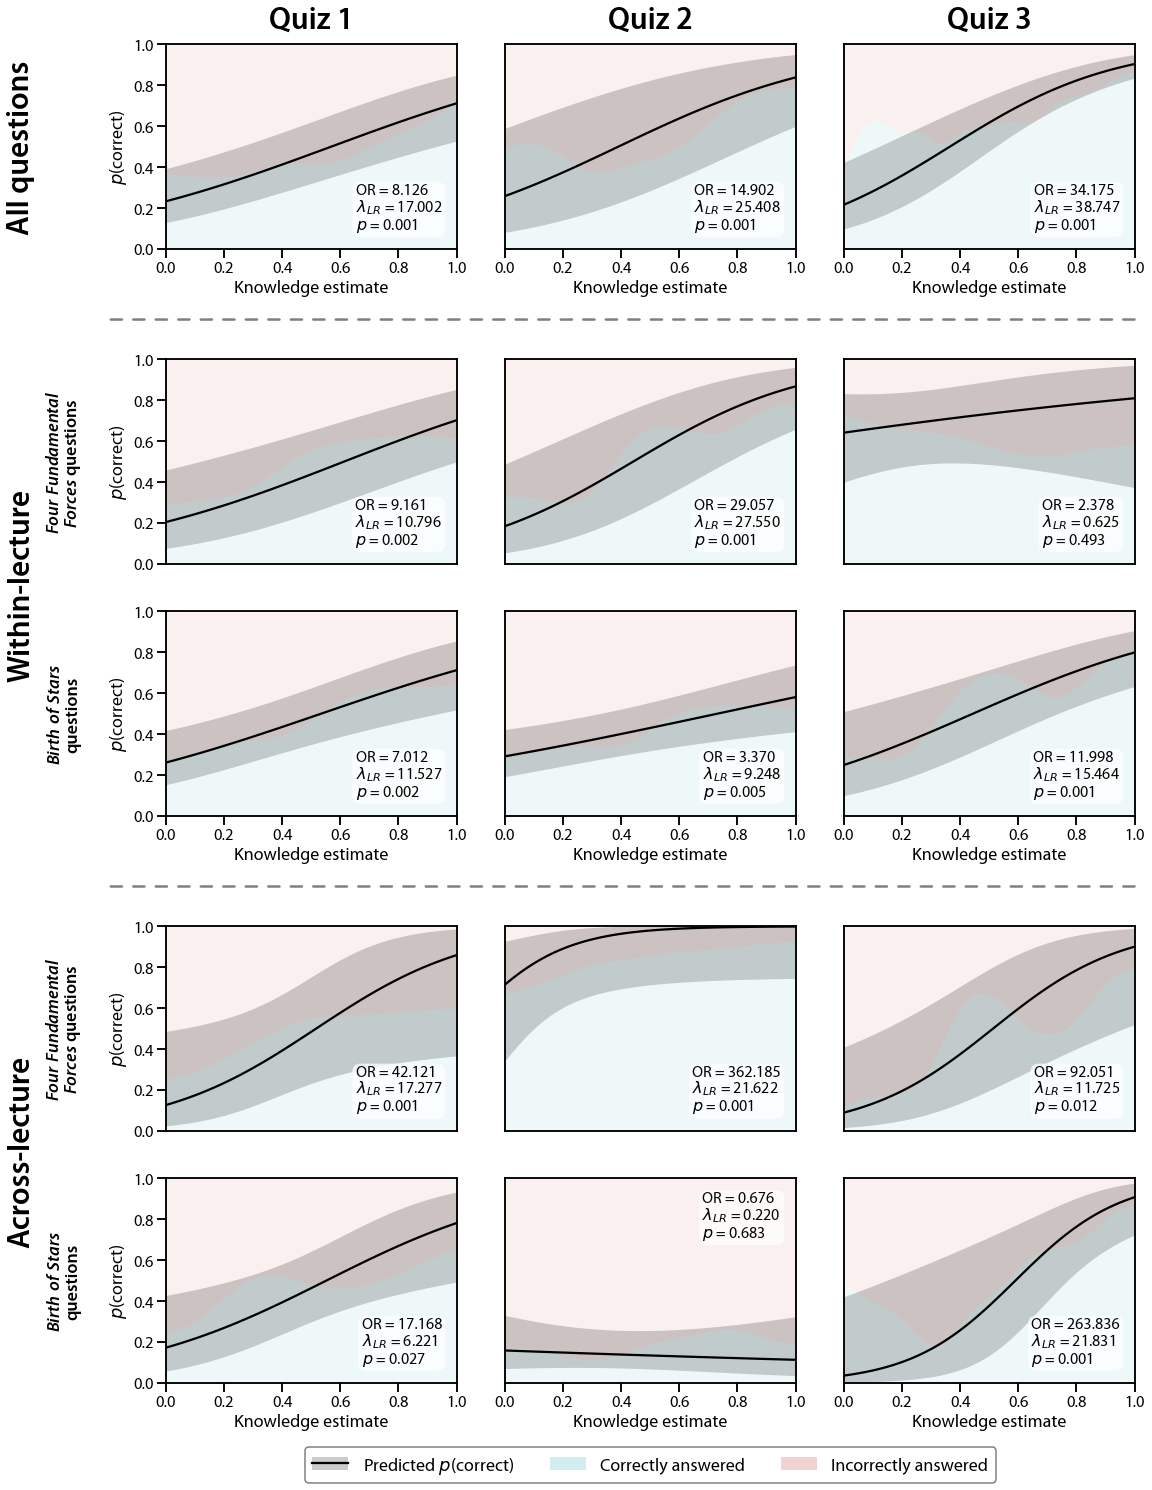

In [27]:
PREDICTION_CURVES_COLOR = 'k'          # color for predicted probability curves
PREDICTION_CIS_ALPHA = 0.2             # opacity for confidence intervals
BG_DENSITY_ALPHA = 0.1                 # opacity for background density plot

STATS_BOX_ALPHA = 0.75                 # opacity for stats annotation bounding box
STATS_BOX_PAD = 0.2                    # padding between stats text and bounding box edge
STATS_BOX_LOCS = {                     # placement options for stats annotation
    'lower right': (0.95, 0.075),
    'upper right': (0.95, 0.69)
}
STATS_UR_AXES = [                      # panels with stats boxes in upper right instead of lower right
    ('quiz2', 'lec2_across'),
]

LEGEND_AXES_HEIGHT_RATIO = 0.2         # height of legend axes relative to subplots
LEGEND_DENSITY_HANDLE_ALPHA = 0.3      # opacity for handles for background density plots

SEPLINE_AXES_HEIGHT_RATIO = 0.075      # height of separator line axes relative to subplots
SEPLINE_YAXIS_FRAC = -0.5              # vertical offset of separator line as a fraction of y-axis height
SEPLINE_PATCH_KWARGS = {               # common kwargs for horizontal separator lines
    'xyA': (-0.19, SEPLINE_YAXIS_FRAC), 
    'xyB': (1, SEPLINE_YAXIS_FRAC), 
    'coordsA': 'axes fraction', 
    'coordsB': 'axes fraction',
    'linestyle': (0, (4.5, 4.5)),
    'linewidth': 2.5,
    'color': 'grey'
}

CONDITION_YLABEL_KWARGS = {            # common kwargs for vertical condition labels
    'x': -0.45,
    'fontsize': 'xx-large',
    'fontweight': 'semibold',
    'rotation': 90,
    'horizontalalignment': 'right',
    'verticalalignment': 'center'
}
LECTURE_YLABEL_KWARGS = {              # common kwargs for vertical lecture labels
    'x': -0.35,
    'y': 0.5,
    'fontsize': 'medium',
    'fontweight': 'semibold',
    'linespacing': 1,
    'rotation': 90,
    'horizontalalignment': 'center',
    'verticalalignment': 'center'
}


with sns.plotting_context('talk'):
    
    # ======================= set up axes layout =======================
    
    fig = plt.figure(figsize=(15, 21), tight_layout={'h_pad': 0})
    gs = fig.add_gridspec(8, 3, height_ratios=(
        1, 
        SEPLINE_AXES_HEIGHT_RATIO, 
        1, 
        1, 
        SEPLINE_AXES_HEIGHT_RATIO, 
        1, 
        1, 
        LEGEND_AXES_HEIGHT_RATIO
    ))
    
    axes_dict = {
        f'quiz{quiz_n}': {
            cond: fig.add_subplot(gs[row_ix, quiz_n - 1]) 
            for (cond, row_ix) in zip(CONDITIONS, (0, 2, 3, 5, 6)) 
        } 
        for quiz_n in range(1, 4)
    }

    # set reference axes (top left subplot) for controlling all 
    # subplots' x- and y-axes range, styling, etc.
    reference_ax = fig.axes[0]
    for ax in fig.axes[1:]:
        ax.sharex(reference_ax)
        ax.sharey(reference_ax)
        
    reference_ax.set_xlim(0, 1)
    reference_ax.set_ylim(0, 1)
        
    # add axes for separator lines & legend
    sep1_axes = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 2])]
    sep2_axes = [fig.add_subplot(gs[4, 0]), fig.add_subplot(gs[4, 2])]
    legend_ax = fig.add_subplot(gs[7, :])
    
    # ================= plot observations & model fits =================
    
    for quiz_n in range(1, 4):
        quiz_key = f'quiz{quiz_n}'
        for cond in CONDITIONS:
            ax = axes_dict[quiz_key][cond]
            model = models[quiz_key][cond]['mod']
            predictions_df = models[quiz_key][cond]['predicted_probs']

            # plot predicted probability curve
            ax.plot(predictions_df['x'], 
                    predictions_df['predicted'], 
                    color=PREDICTION_CURVES_COLOR)
            ax.fill_between(x=predictions_df['x'], 
                            y1=predictions_df['conf.low'], 
                            y2=predictions_df['conf.high'],
                            color=PREDICTION_CURVES_COLOR,
                            edgecolor=None,
                            alpha=PREDICTION_CIS_ALPHA)
            
            sns.kdeplot(x=model.coefs.index[1], 
                        data=model.data, 
                        hue='accuracy', 
                        hue_order=('incorrect', 'correct'), 
                        palette=(INCORRECT_ANSWER_COLOR, CORRECT_ANSWER_COLOR),
                        multiple='fill', 
                        alpha=BG_DENSITY_ALPHA, 
                        edgecolor=None, 
                        legend=False,
                        ax=ax)
            
    # ====================== add stats annotation ======================
        
            odds_ratio = np.exp(model.coefs['Estimate'][1])
            lrt_result = models[quiz_key][cond]['lrt'].loc[1, 'Chisq']
            p_val = models[quiz_key][cond]['p_boot']
            
            stats_str = format_stats(odds_ratio, lrt_result, p_val)
            if (quiz_key, cond) in STATS_UR_AXES:
                annot_xy = STATS_BOX_LOCS['upper right']
            else:
                annot_xy = STATS_BOX_LOCS['lower right']
            annotate_textbox(stats_str, 
                             annot_xy=annot_xy, 
                             text_pad=STATS_BOX_PAD,
                             rounded=True,
                             rounding_size=0.5,
                             blur=False,
                             blur_size=0.05,
                             blur_n_steps=10,
                             ax=ax,
                             annot_kwargs={'fontsize': 16, 
                                           'linespacing': 1,
                                           'horizontalalignment': 'right', 
                                           'verticalalignment': 'bottom', 
                                           'multialignment': 'left'},
                             rect_kwargs={'facecolor': 'white', 
                                          'alpha': STATS_BOX_ALPHA})
            
    # ====================== add separator lines =======================
    
    fig.add_artist(ConnectionPatch(axesA=sep1_axes[0], 
                                   axesB=sep1_axes[1], 
                                   **SEPLINE_PATCH_KWARGS))
    fig.add_artist(ConnectionPatch(axesA=sep2_axes[0], 
                                   axesB=sep2_axes[1], 
                                   **SEPLINE_PATCH_KWARGS))
    for ax in sep1_axes + sep2_axes:
        ax.axis('off')
        
    # ======================= add shared legend ========================
    
    pred_errband, correct_bg, incorrect_bg = reference_ax.collections
    pred_line2d = reference_ax.lines[0]
    
    leg = legend_ax.legend(handles=((pred_line2d, pred_errband), 
                                    correct_bg, 
                                    incorrect_bg),
                     labels=('Predicted $p$(correct)', 
                             'Correctly answered', 
                             'Incorrectly answered'),
                     loc='lower center',
                     ncol=3,
                     fontsize='medium',
                     edgecolor='grey',
                     framealpha=1,
                     bbox_to_anchor=(0.5, -0.5))
    correct_handle, incorrect_handle = leg.legendHandles[1:]
    correct_handle.set_facecolor((*correct_handle.get_facecolor()[:3], 
                                  LEGEND_DENSITY_HANDLE_ALPHA))
    incorrect_handle.set_facecolor((*incorrect_handle.get_facecolor()[:3], 
                                    LEGEND_DENSITY_HANDLE_ALPHA))

    legend_ax.axis('off')
    
    # ==================== format axes, add labels =====================
        
    for quiz_n in range(1, 4):
        for cond in CONDITIONS:
            ax = axes_dict[f'quiz{quiz_n}'][cond]
            
            if cond.startswith('lec1'):
                ax.xaxis.set_visible(False)
                ax.tick_params(bottom=False, labelbottom=False)
            else:
                ax.set_xlabel('Knowledge estimate')
            
            if quiz_n == 1:
                ax.set_ylabel('$p$(correct)')
            else:
                ax.yaxis.set_visible(False)
                ax.tick_params(left=False, labelleft=False)
            
            if cond == 'all_questions':
                ax.set_title(f'Quiz {quiz_n}', 
                             y=1.05, 
                             fontsize='xx-large', 
                             fontweight='semibold')
                
    fig.text(y=0.5,
             s='All questions',
             transform=axes_dict['quiz1']['all_questions'].transAxes, 
             **CONDITION_YLABEL_KWARGS)
    fig.text(y=-0.1,
             s='Within-lecture',
             transform=axes_dict['quiz1']['lec1_within'].transAxes, 
             **CONDITION_YLABEL_KWARGS)
    fig.text(y=-0.1,
             s='Across-lecture',
             transform=axes_dict['quiz1']['lec1_across'].transAxes, 
             **CONDITION_YLABEL_KWARGS)
    
    with (
        disable_logging('matplotlib.font_manager', 'ERROR'), 
        plt.rc_context({
            'mathtext.fontset': 'custom', 
            'mathtext.it': 'sans:semibold:italic'
        })
    ):
        fig.text(s='$\\mathit{{Four\ Fundamental}}$\n$\\mathit{{Forces}}$ questions',
                 transform=axes_dict['quiz1']['lec1_across'].transAxes, 
                 **LECTURE_YLABEL_KWARGS)
        fig.text(s='$\\mathit{{Birth\ of\ Stars}}$\nquestions',
                 transform=axes_dict['quiz1']['lec2_across'].transAxes, 
                 **LECTURE_YLABEL_KWARGS)
        fig.text(s='$\\mathit{{Four\ Fundamental}}$\n$\\mathit{{Forces}}$ questions',
                 transform=axes_dict['quiz1']['lec1_within'].transAxes, 
                 **LECTURE_YLABEL_KWARGS)
        fig.text(s='$\\mathit{{Birth\ of\ Stars}}$\nquestions',
                 transform=axes_dict['quiz1']['lec2_within'].transAxes, 
                 **LECTURE_YLABEL_KWARGS)
        
#         plt.savefig(FIG_DIR.joinpath('predict-knowledge-questions.pdf'), 
#                     bbox_inches='tight',
#                     dpi=300)
        plt.show()

# Compute 95% CIs for odds ratios for reporting

In [28]:
for quiz_n in range(1, 4):
    print(f'Quiz {quiz_n}:')
    for cond in CONDITIONS:
        print(f'\t{cond}:')     
        coefs = models[f'quiz{quiz_n}'][cond]['mod'].coefs
        log_ci_bounds = coefs[['2.5_ci', '97.5_ci']].to_numpy()[1]
        ci_low, ci_high = np.exp(log_ci_bounds)
        print(f'\t\t{np.exp(coefs["Estimate"][1])}')
        print(f'\t\tOR 95% CI: ({ci_low}, {ci_high})')

Quiz 1:
	all_questions:
		8.125844093851807
		OR 95% CI: (3.2348624123991736, 20.41179309033266)
	lec1_within:
		9.160939115732655
		OR 95% CI: (2.8942681176815626, 28.996209773884555)
	lec2_within:
		7.012462959240231
		OR 95% CI: (2.4515103598157038, 20.05891452092948)
	lec1_across:
		42.121371244355494
		OR 95% CI: (1.1680710385253226, 1518.922956727648)
	lec2_across:
		17.1683740228521
		OR 95% CI: (2.027898491013761, 145.34902407328758)
Quiz 2:
	all_questions:
		14.90219287952224
		OR 95% CI: (5.4033443272180985, 41.09961149427958)
	lec1_within:
		29.05749194630679
		OR 95% CI: (6.433448307330989, 131.24187805279342)
	lec2_within:
		3.3696574211835872
		OR 95% CI: (1.5190577787523583, 7.474759219141385)
	lec1_across:
		362.18514537687065
		OR 95% CI: (0.8948850087225158, 146586.5203384363)
	lec2_across:
		0.6760049064734327
		OR 95% CI: (0.1274896068232018, 3.5844697066944615)
Quiz 3:
	all_questions:
		34.17521808979294
		OR 95% CI: (10.693325937418962, 109.2219145212754)
	lec1_wi